In [1]:
import numpy as np
import scipy as scipy
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random

Toy model with two hypotheses

For discovery:  
H0: background only   
H1: signal + background  
              
For upper limit setting  
H0: signal + background  
H1: background only  
              
              
**Test statistic**  

$ t= -2 ln(\frac{\mathscr{L}(\mu, \hat{\hat{\theta}})}{\mathscr{L}(\hat{\mu}, \hat{\theta})}) $

**Parameters**  

$\theta = (\mu,b_{CR})$  
POI: $\mu$ : signal strength parameter  
NP: $b_{CR}$ background in the control region  



**Profile likelihood ratio**  


- $\lambda(\mu) = \frac{\mathscr{L}(\mu, \hat{\hat{\nu}})}{\mathscr{L}(\hat{\mu}, \hat{\nu})}$


- $\mu$: hypothesized value chosen.  


- $\hat{\mu}$: Maximum likelihood estimator (MLE) for $\mu$ - depends on observed data and is chosen such that the likelihood is maximised.  


- $\hat{\hat{\nu}}$: conditional maximum likelihood estimator for $\nu$, depends on chosen $\mu$ and observed data - maximises $\mathscr{L}$ for that specific $\mu$.  


- $\hat{\nu}$: MLE from data.  


- $\mathscr{L}(\mu,\mathbf{\nu})= \mathscr{L}(SR) x \mathscr{L}(CR)$  


- $\frac{\partial{\mathscr{L}(\mu,\nu)}}{\partial{\nu}} = 0$: gives the ML estimators.  

In [2]:
experiments = 2000
s0 = 1     #nominal signal events = 1
r = 0.2

H0: Bkg

In [3]:
## control region ##
background_CR_H0   = 5000.0 
signal_CR_H0   =  0.0  
events_CR_H0 = background_CR_H0 + signal_CR_H0    #total expected events
mu_CR_H0    = signal_CR_H0/s0   #expected POI
lam_CR_H0 = mu_CR_H0 * s0 + background_CR_H0
observed_events_CR_H0 = poisson.rvs(mu=lam_CR_H0, loc=0.0, size=experiments)

## signal region ##
background_SR_H0  =1000.0
#= r * background_CR_H0
signal_SR_H0   =  0.0  
events_SR_H0 = background_SR_H0 + signal_SR_H0    #total expected events
mu_SR_H0    = signal_SR_H0/s0   #expected POI
lam_SR_H0 = mu_SR_H0 * s0 + background_SR_H0

observed_events_SR_H0 = poisson.rvs(mu=lam_SR_H0, loc=0.0, size=experiments)

H1: sig + bkg

bkg_CR = r * bkg_SR

In [4]:
## control region ##
background_CR_H1   = 5000.0    #expected bkg in CR
signal_CR_H1 = 0.0    #expected signal in cR
events_CR_H1 = background_CR_H1 + signal_CR_H1    #expected events in control region
#mu_CR_H0 = background_CR_H0
lam_CR_H1 = signal_CR_H1 * s0 + background_CR_H1   # = bkg_CR_H0
observed_events_CR_H1 = poisson.rvs(mu = lam_CR_H1, loc=0.0, size=experiments)

## signal region ##
background_SR_H1 = 1000.0
#r * background_CR_H1
signal_SR_H1 = 50.0
#signal_SR_H1   =  random.randint(0,50)   #unknown signal sig - random  
events_SR_H1 = background_SR_H1 + signal_SR_H1    #total expected events in SR
mu_SR_H1 = signal_SR_H1/s0   #expected POI
lam_SR_H1 = mu_SR_H1 * s0 + background_SR_H1
observed_events_SR_H1 = poisson.rvs(mu=lam_SR_H1, loc=0.0, size=experiments)


Text(0,0.5,'Frequency')

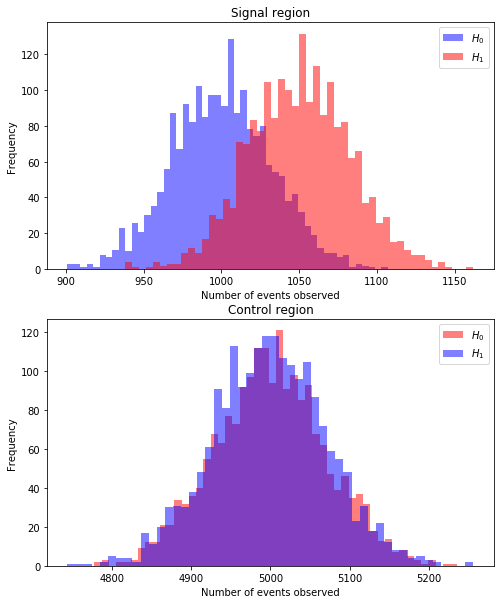

In [5]:
f, a= plt.subplots(nrows=2, figsize=(8,10))
#f.subplots_adjust(hspace=0.3)
a = a.flatten()
a[0].hist(observed_events_SR_H0, bins=50, color='b', alpha=0.5, label=r'$H_{0}$')
a[0].hist(observed_events_SR_H1, bins=50, color='r', alpha=0.5, label=r'$H_{1}$')
a[0].set_title("Signal region")
a[0].set_xlabel("Number of events observed")
a[0].set_ylabel("Frequency")
a[0].legend()
a[1].hist(observed_events_CR_H0, bins=50, color='r', alpha=0.5, label=r'$H_{0}$');
a[1].hist(observed_events_CR_H1, bins=50, color='b', alpha=0.5, label=r'$H_{1}$');
a[1].set_title("Control region")
a[1].legend()
a[1].set_xlabel("Number of events observed")
a[1].set_ylabel("Frequency")

In [6]:
def likelihood(mu, n, background):
    s0 = 1.0
    signal = mu * s0
    expected_events = signal + background
    likelihood = poisson.pmf(n, mu=expected_events)
    return likelihood

In [7]:
def log_likelihood(mu, n,background):
    s0 = 1
    signal = mu * s0
    expected_events = signal + background
    log_likelihood = poisson.logpmf(n, mu=expected_events)  
    return log_likelihood

In [19]:
## L_model = L(SR) * L(CR)
## ln L_model = ln(L(SR)*L(CR)) = ln(L(SR)) + ln(L(CR))

def model_log_likelihood(mu, bkg_CR, SR_events, CR_events):
    bkg_SR = bkg_CR * 0.2  # r=0.2
    ll_SR = log_likelihood(mu = mu, n = SR_events, background = bkg_SR)
    ll_CR = log_likelihood(mu = mu, n = CR_events, background = bkg_CR)
    return ll_SR+ll_CR

In [20]:
def neg_log_l_free(x, SR_events, CR_events):
    mu   = x[0]
    background_CR = x[1]
    log_likelihood_free = model_log_likelihood(mu, background_CR, SR_events, CR_events)
    return -log_likelihood_free

In [21]:
def neg_log_l_cond(x, SR_events, CR_events):
    mu   = 0
    background_CR = x
    log_likelihood_cond = model_log_likelihood(mu, background_CR, SR_events, CR_events)
    return -log_likelihood_cond

In [22]:
def maximise_LL(SR_events,CR_events, mu):
    
    fit_result_free = minimize(neg_log_l_free, x0=[1.0, 5000.0], args=(SR_events,CR_events), method='Nelder-Mead') 
    LL_free = -fit_result_free['fun'] 
    parameter_MLE_free = fit_result_free['x']
    mu_fit_free = parameter_MLE_free[0]
    bkg_CR_free = parameter_MLE_free[1]
    
    fit_result_cond = minimize(neg_log_l_cond, x0=[5000.0], args=(SR_events,CR_events), method='Nelder-Mead') 
    LL_cond = -fit_result_cond['fun'] 
    parameter_MLE_cond = fit_result_cond['x']
    bkg_CR_cond = parameter_MLE_cond

    return (LL_free, mu_fit_free, bkg_CR_free, LL_cond, bkg_CR_cond)

In [23]:
max_LL_results_H0 = [maximise_LL(SR,CR, mu_SR_H0) for SR,CR in zip(observed_events_SR_H0,observed_events_CR_H0)]
max_LL_results_H0 = np.array(max_LL_results_H0)
#using mu for H0: sig + bkg
max_LL_results_H1 = [maximise_LL(SR,CR, mu_SR_H0) for SR,CR in zip(observed_events_SR_H1,observed_events_CR_H1)]
max_LL_results_H1 = np.array(max_LL_results_H1)

Distribution of LL_free and LL_cond for H0 and H1

C:\Users\Natasha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


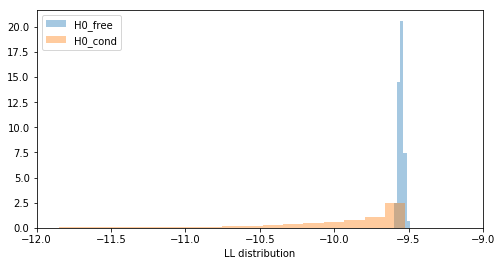

In [37]:
f,a = plt.subplots(figsize = (8,4))
a.hist(max_LL_results_H0[:,0], bins=50, alpha=0.4, label = 'H0_free',normed = True)
a.hist(max_LL_results_H0[:,3], bins=50, alpha=0.4, label='H0_cond', normed = True)
a.set_xlim(-12, -9.0)
a.set_xlabel("LL distribution for H0")
a.legend()

C:\Users\Natasha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


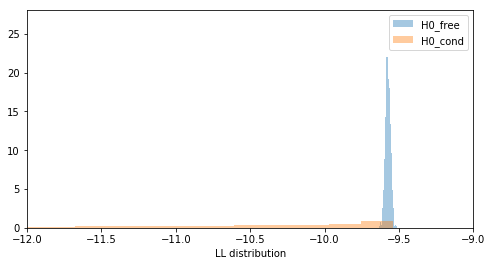

In [38]:
f,a = plt.subplots(figsize = (8,4))
a.hist(max_LL_results_H1[:,0], bins=50, alpha=0.4, label = 'H1_free',normed = True)
a.hist(max_LL_results_H1[:,3], bins=50, alpha=0.4, label='H1_cond', normed = True)
a.set_xlim(-12, -9)
a.set_xlabel("LL distribution for H1")
a.legend()

MLE mu_hat vs b_CR_hat distribution

Text(0.5,1,'Best fit $(\\hat{\\mu},\\hat{b}_{CR})$')

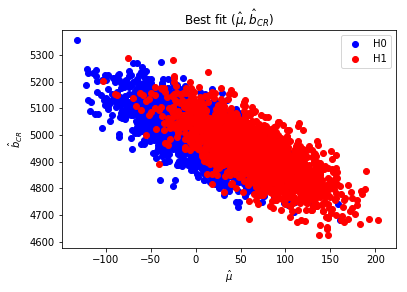

In [39]:
f,ax = plt.subplots()
ax.scatter(max_LL_results_H0[:,1], max_LL_results_H0[:,2], c='b', label=r"H0")
ax.scatter(max_LL_results_H1[:,1], max_LL_results_H1[:,2], c='r', label=r"H1")
ax.set_xlabel(r'$\hat{\mu}$')
ax.set_ylabel(r'$\hat{b}_{CR}$')
ax.legend()
ax.set_title(r"Best fit $(\hat{\mu},\hat{b}_{CR})$")

Distribution for mu hat under H0 and H1

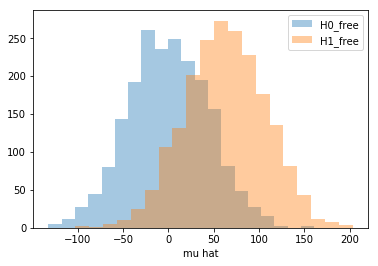

In [16]:
f,a = plt.subplots()
a.hist(max_LL_results_H0[:,1], bins=20, alpha=0.4 , label = "H0_free")
a.hist(max_LL_results_H1[:,1], bins=20, alpha=0.4, label = "H1_free")
a.set_xlabel("mu hat")
a.legend()

In [ ]:
Distribution of the test statistic

In [40]:
LL_free_H0 = max_LL_results_H0[:,0]
LL_free_H1 = max_LL_results_H1[:,0]
LL_cond_H0 = max_LL_results_H0[:,3]
LL_cond_H1 = max_LL_results_H1[:,3]

t_H0 = -2.0*(LL_cond_H0 - LL_free_H0)
t_H1 = -2.0*(LL_cond_H1 - LL_free_H1) 

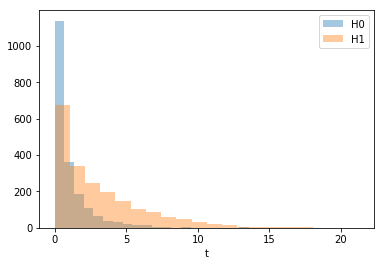

In [41]:
f,a = plt.subplots()
a.hist(t_H0, bins=20, alpha=0.4, label='H0')
a.hist(t_H1, bins=20, alpha=0.4, label='H1')
a.set_xlabel('t')
a.legend()